In [37]:
import json
import pandas as pd
from openai import OpenAI

client = OpenAI()  # <-- use env var OPENAI_API_KEY instead of hardcoding

EVENT_SCHEMA = {
    "type": "object",
    "additionalProperties": False,
    "properties": {
        "doc_id": {"type": "string"},
        "language": {"type": "string", "enum": ["sr", "hr", "bs", "me", "und"]},
        "events": {
            "type": "array",
            "items": {
                "type": "object",
                "additionalProperties": False,
                "properties": {
                    "event_type": {
                        "type": "string",
                        "enum": [
                            "protest_rally","traffic_blockade","institutional_blockade","march_walk",
                            "vigil_commemoration","strike_boycott","clash_police_action","arrest_detention",
                            "investigation_charges_trial","resignation_dismissal","government_response_policy",
                            "counter_rally","international_reaction","election","other"
                        ]
                    },
                    "trigger": {"type": ["string", "null"]},
                    "locations": {"type": "array", "items": {"type": "string"}},
                    "actors": {"type": "array", "items": {"type": "string"}},
                    "time_mentions": {"type": "array", "items": {"type": "string"}},
                    "confidence": {"type": "number", "minimum": 0, "maximum": 1},
                    "notes": {"type": ["string", "null"]}
                },
                "required": ["event_type", "trigger", "locations", "actors", "time_mentions", "confidence", "notes"]
            }
        }
    },
    "required": ["doc_id", "language", "events"]
}

SYSTEM_INSTRUCTIONS = """You extract events from Serbian/Croatian/Bosnian/Montenegrin news text.
Rules:
- Output MUST follow the JSON schema exactly.
- Do NOT invent details. If a field is not explicitly supported by the text, use null (or empty list).
- Keep strings in the original script/language; do not translate.
- If there are no events, return events: [].
- Return one result per DOC_ID.
"""

def extract_events(doc_id: str, text: str, model: str = "gpt-4o-2024-08-06"):
    resp = client.responses.create(
        model=model,
        input=[
            {"role": "system", "content": SYSTEM_INSTRUCTIONS},
            {"role": "user", "content": f"doc_id: {doc_id}\n\nTEXT:\n{text}"}
        ],
        text={
            "format": {
                "type": "json_schema",
                "name": "event_extraction",
                "strict": True,
                "schema": EVENT_SCHEMA
            }
        },
        store=False,
    )
    return json.loads(resp.output_text)

# --------- NEW: batch wrapper (minimal addition) ---------
BATCH_SCHEMA = {
    "type": "object",
    "additionalProperties": False,
    "properties": {
        "results": {
            "type": "array",
            "items": EVENT_SCHEMA
        }
    },
    "required": ["results"]
}

def extract_events_batch(docs, model: str = "gpt-4o-2024-08-06"):
    """
    docs: list of (doc_id, text)
    returns: list of dicts matching EVENT_SCHEMA
    """
    payload = "\n\n".join(
        [f"### DOC {i}\nDOC_ID: {doc_id}\nTEXT:\n{text}"
         for i, (doc_id, text) in enumerate(docs, start=1)]
    )

    resp = client.responses.create(
        model=model,
        input=[
            {"role": "system", "content": SYSTEM_INSTRUCTIONS},
            {"role": "user", "content": payload}
        ],
        text={
            "format": {
                "type": "json_schema",
                "name": "event_extraction_batch",
                "strict": True,
                "schema": BATCH_SCHEMA
            }
        },
        store=False,
    )

    out = json.loads(resp.output_text)
    return out["results"]

def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]




In [ ]:

df["doc_id"] = df.index.astype(str)


pairs = list(zip(df["doc_id"], df["headline"].astype(str)))

all_results = []
for batch in chunk_list(pairs, 100):  # for headlines, 100 is a reasonable start
    all_results.extend(extract_events_batch(batch))

res_df = pd.DataFrame(all_results)  # columns: doc_id, language, events
df = df.merge(res_df, on="doc_id", how="left")

df.head()

In [9]:
df.to_csv("events_extracted.csv")

In [5]:
import pandas as pd
df= pd.read_csv("/content/random_headlines.csv",sep=";")

In [11]:
import pandas as pd

events=pd.read_csv("/content/events_extracted_correct.csv", sep=";")


In [12]:

accuracy = events["event_correct"].mean()
print(accuracy)

0.9320987654320988


,events
0,"[{'event_type': 'international_reaction', 'tri..."
1,"[{'event_type': 'other', 'trigger': 'sprovodi ..."
2,"[{'event_type': 'arrest_detention', 'trigger':..."
3,"[{'event_type': 'clash_police_action', 'trigge..."
4,[]
...,...
136,"[{'event_type': 'investigation_charges_trial',..."
137,"[{'event_type': 'clash_police_action', 'trigge..."
138,"[{'event_type': 'institutional_blockade', 'tri..."
139,"[{'event_type': 'clash_police_action', 'trigge..."


In [19]:
import pandas as pd
import ast

events["events"] = events["events"].dropna().apply(ast.literal_eval)

ev = events[events["events"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()


ev = ev.explode("events")


ev["event_type"] = ev["events"].apply(lambda d: d.get("event_type") if isinstance(d, dict) else None)

counts = ev["event_type"].value_counts()
counts

,count
event_type,
protest_rally,29
arrest_detention,20
clash_police_action,19
institutional_blockade,11
traffic_blockade,10
investigation_charges_trial,10
strike_boycott,9
international_reaction,7
resignation_dismissal,6


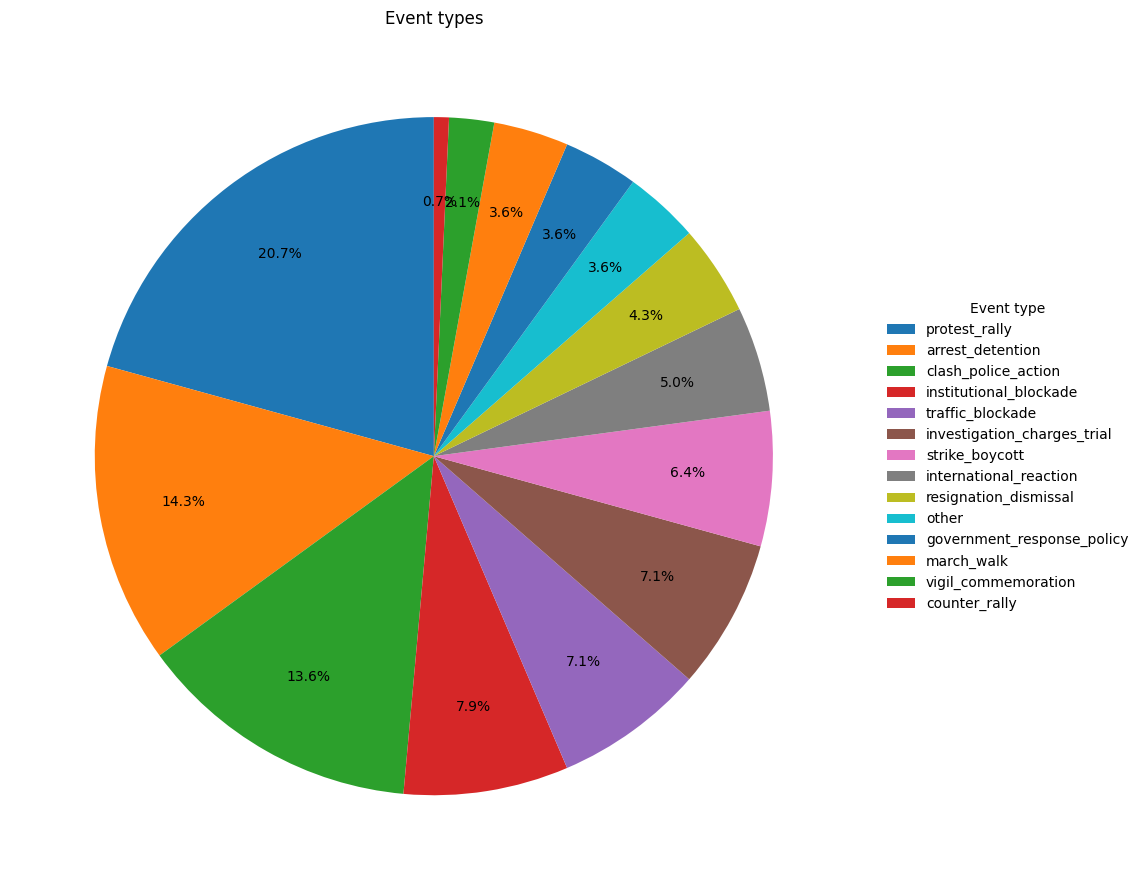

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 9))

wedges, _, autotexts = ax.pie(
    counts.values,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.75,
    textprops={"fontsize": 10},
)

ax.legend(
    wedges,
    counts.index,
    title="Event type",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)

ax.set_title("Event types")
plt.tight_layout()
plt.show()


In [28]:
lemmatized=pd.read_csv("/content/n1_lemmatized.csv")

In [34]:
lemmatized=lemmatized.sample(n=500, random_state=0)

In [35]:
lem=lemmatized["lemmatized"]

In [36]:
non_lem=lemmatized["headline"]

In [40]:
lem["doc_id"] = lem.index.astype(str)


pairs = list(zip(lem["doc_id"], lem.astype(str)))
print(pairs)

[('1814', 'Vučević nazvati idiotima čovjek koji sebe boriti za generalštab : " pokušaj uništavanje Srbija " '), ('29824', 'održan protest poljoprivrednik u Badovinc : poručili - nemojte mi stajati na put '), ('7628', 'porodica student za N1 : Bogdan pretučen kod pionirski park , na pregled u urgentn centar '), ('5745', '( VIDEO ) inspekcija ponovo na vrato radnja aktivista iz užica : " poslušnik vršiti represija nad građanin " '), ('231', 'Selaković o generalštabu : nemati trunčica korupcija u onaj što sebe politički montirati kolega i ja '), ('31982', '" dekan mi pretiti disciplinski prijava " : nastavljen blokada filozofski u Novi Sad '), ('21601', '" postojati opasnost za završetak školski godina " : u forum srednji škola predlagati sažimanje gradiv '), ('27727', 'nov američki administracija protiv madurovi režim , kako htjeti gledati na veza Vučić sa Venecuela ? '), ('9826', 'roditelj , nastavnik i učenik ispred pete beogradski gimnazija , protest zbog odmazda nad prosvetni radnik 

In [48]:
lem=pd.DataFrame(lem)
lem

,lemmatized
1814,Vučević nazvati idiotima čovjek koji sebe bori...
29824,održan protest poljoprivrednik u Badovinc : po...
7628,porodica student za N1 : Bogdan pretučen kod p...
5745,( VIDEO ) inspekcija ponovo na vrato radnja ak...
231,Selaković o generalštabu : nemati trunčica kor...
...,...
11158,napadnuta dvojica novinar u incident u Novi Sa...
31214,BIRN : Srbija uvoziti oprema za masovan nadzor...
31511,"objavljeni dobitnik nagrada "" Srđan Aleksić "" ..."
13379,"ministar Darko Glišić zapretiti "" blokaderima ..."


In [49]:
lem=pd.DataFrame(lem)
lem["doc_id"] = lem.index.astype(str)


pairs = list(zip(lem["doc_id"], lem["lemmatized"].astype(str)))
print(pairs)
all_results = []
for batch in chunk_list(pairs, 100):
    all_results.extend(extract_events_batch(batch))

res_df = pd.DataFrame(all_results)
lem= lem.merge(res_df, on="doc_id", how="left")

lem.head()

[('1814', 'Vučević nazvati idiotima čovjek koji sebe boriti za generalštab : " pokušaj uništavanje Srbija " '), ('29824', 'održan protest poljoprivrednik u Badovinc : poručili - nemojte mi stajati na put '), ('7628', 'porodica student za N1 : Bogdan pretučen kod pionirski park , na pregled u urgentn centar '), ('5745', '( VIDEO ) inspekcija ponovo na vrato radnja aktivista iz užica : " poslušnik vršiti represija nad građanin " '), ('231', 'Selaković o generalštabu : nemati trunčica korupcija u onaj što sebe politički montirati kolega i ja '), ('31982', '" dekan mi pretiti disciplinski prijava " : nastavljen blokada filozofski u Novi Sad '), ('21601', '" postojati opasnost za završetak školski godina " : u forum srednji škola predlagati sažimanje gradiv '), ('27727', 'nov američki administracija protiv madurovi režim , kako htjeti gledati na veza Vučić sa Venecuela ? '), ('9826', 'roditelj , nastavnik i učenik ispred pete beogradski gimnazija , protest zbog odmazda nad prosvetni radnik 

,lemmatized,doc_id,language,events
0,Vučević nazvati idiotima čovjek koji sebe bori...,1814,sr,[]
1,održan protest poljoprivrednik u Badovinc : po...,29824,sr,"[{'event_type': 'protest_rally', 'trigger': 'p..."
2,porodica student za N1 : Bogdan pretučen kod p...,7628,sr,"[{'event_type': 'other', 'trigger': 'pretučen'..."
3,( VIDEO ) inspekcija ponovo na vrato radnja ak...,5745,sr,"[{'event_type': 'investigation_charges_trial',..."
4,Selaković o generalštabu : nemati trunčica kor...,231,sr,[]


In [50]:
lem

,lemmatized,doc_id,language,events
0,Vučević nazvati idiotima čovjek koji sebe bori...,1814,sr,[]
1,održan protest poljoprivrednik u Badovinc : po...,29824,sr,"[{'event_type': 'protest_rally', 'trigger': 'p..."
2,porodica student za N1 : Bogdan pretučen kod p...,7628,sr,"[{'event_type': 'other', 'trigger': 'pretučen'..."
3,( VIDEO ) inspekcija ponovo na vrato radnja ak...,5745,sr,"[{'event_type': 'investigation_charges_trial',..."
4,Selaković o generalštabu : nemati trunčica kor...,231,sr,[]
...,...,...,...,...
496,napadnuta dvojica novinar u incident u Novi Sa...,11158,NaN,NaN
497,BIRN : Srbija uvoziti oprema za masovan nadzor...,31214,NaN,NaN
498,"objavljeni dobitnik nagrada "" Srđan Aleksić "" ...",31511,NaN,NaN
499,"ministar Darko Glišić zapretiti "" blokaderima ...",13379,NaN,NaN


In [51]:

n_nan = lem["events"].isna().sum()


n_empty_list = lem["events"].apply(lambda x: isinstance(x, list) and len(x) == 0).sum()


print("NaN:", n_nan)
print("Empty []:", n_empty_list)



NaN: 104
Empty []: 211


In [43]:
res_df = pd.DataFrame(all_results)

In [46]:
res_df

,doc_id,language,events
0,1814,und,[]
1,29824,und,"[{'event_type': 'protest_rally', 'trigger': 'p..."
2,7628,und,"[{'event_type': 'clash_police_action', 'trigge..."
3,5745,und,"[{'event_type': 'investigation_charges_trial',..."
4,231,und,[]
...,...,...,...
195,13917,sr,"[{'event_type': 'clash_police_action', 'trigge..."
196,5815,sr,[]
197,10476,sr,[]
198,27634,sr,"[{'event_type': 'clash_police_action', 'trigge..."


In [45]:
lem= pd.DataFrame(lem).merge(res_df, on="doc_id", how="left")

lem.head()

KeyError: 'doc_id'

In [59]:


lemmatized["doc_id"] = lemmatized.index.astype(str)


pairs = list(zip(lemmatized["doc_id"], lemmatized['headline'].astype(str)))



In [60]:
all_results = []
for batch in chunk_list(pairs, 100):
    all_results.extend(extract_events_batch(batch))

res_df = pd.DataFrame(all_results)
lemmatized= lemmatized.merge(res_df, on="doc_id", how="left")

lemmatized.head()

,Unnamed: 0,headline,url,datePublished,author,Related,Scores,spacy_doc,lemmatized,ner,doc_id,language,events
0,1814,Vučević nazvao idiotima ljude koji se bore za ...,/vesti/vucevic-nazvao-idiotima-ljude-koji-se-b...,2025-12-19 09:29:01.043365+00:00,"{'@type': 'Person', 'name': 'Beta '}",False,"[0.7954736948013306, 0.20452630519866943]",Vučević nazvao idiotima ljude koji se bore za ...,Vučević nazvati idiotima čovjek koji sebe bori...,"[{'entity_group': 'PER', 'score': np.float32(0...",1814,sr,[]
1,29824,Održan protest poljoprivrednika u Badovincima:...,/vesti/blog-uzivo-poljoprivrednici-protest/,2024-12-29 11:52:31+00:00,"{'@type': 'Person', 'name': 'nova.rs '}",False,"[0.9991506338119507, 0.0008493904606439173]",Održan protest poljoprivrednika u Badovincima:...,održan protest poljoprivrednik u Badovinc : po...,"[{'entity_group': 'LOC', 'score': np.float32(0...",29824,sr,"[{'event_type': 'protest_rally', 'trigger': 'p..."
2,7628,Porodica studenta za N1: Bogdan pretučen kod P...,/vesti/studenti-u-blokadi-kolega-nam-je-pretuc...,2025-10-01 19:37:47.112507+00:00,"{'@type': 'Person', 'name': 'N1 Beograd'}",False,"[0.7599595785140991, 0.24004043638706207]",Porodica studenta za N1: Bogdan pretučen kod P...,porodica student za N1 : Bogdan pretučen kod p...,"[{'entity_group': 'ORG', 'score': np.float32(0...",7628,sr,"[{'event_type': 'clash_police_action', 'trigge..."
3,5745,(VIDEO) Inspekcija ponovo na vratima radnje ak...,/vesti/video-inspekcija-ponovo-na-vratima-radn...,2025-10-28 09:34:38.831863+00:00,"{'@type': 'Person', 'name': 'N1 Beograd'}",False,"[0.9953579306602478, 0.00464206887409091]",(VIDEO) Inspekcija ponovo na vratima radnje ak...,( VIDEO ) inspekcija ponovo na vrato radnja ak...,[],5745,sr,[]
4,231,Selaković o Generalštabu: Nema trunčice korupc...,/vesti/selakovic-o-generalstabu-nema-truncice-...,2026-01-14 16:22:15.944004+00:00,"{'@type': 'Person', 'name': 'Beta '}",True,"[0.5492145419120789, 0.45078548789024353]",Selaković o Generalštabu: Nema trunčice korupc...,Selaković o generalštabu : nemati trunčica kor...,"[{'entity_group': 'PER', 'score': np.float32(0...",231,sr,[]


In [61]:
non_lem_ev=lemmatized["events"]

In [63]:

n_nan = non_lem_ev.isna().sum()


n_empty_list =  non_lem_ev.apply(lambda x: isinstance(x, list) and len(x) == 0).sum()


print("NaN:", n_nan)
print("Empty []:", n_empty_list)

NaN: 148
Empty []: 260


In [64]:

lem = lem[lem["events"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

In [76]:
non_lem = non_lem_ev[non_lem_ev.apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

In [77]:
non_lem

,events
1,"[{'event_type': 'protest_rally', 'trigger': 'p..."
2,"[{'event_type': 'clash_police_action', 'trigge..."
5,"[{'event_type': 'institutional_blockade', 'tri..."
8,"[{'event_type': 'protest_rally', 'trigger': 'p..."
12,"[{'event_type': 'vigil_commemoration', 'trigge..."
...,...
511,"[{'event_type': 'institutional_blockade', 'tri..."
513,"[{'event_type': 'vigil_commemoration', 'trigge..."
514,"[{'event_type': 'election', 'trigger': 'izborn..."
516,"[{'event_type': 'election', 'trigger': 'glasov..."


In [72]:
lem["events"]

,events
1,"[{'event_type': 'protest_rally', 'trigger': 'p..."
2,"[{'event_type': 'other', 'trigger': 'pretučen'..."
3,"[{'event_type': 'investigation_charges_trial',..."
5,"[{'event_type': 'institutional_blockade', 'tri..."
8,"[{'event_type': 'protest_rally', 'trigger': 'p..."
...,...
452,"[{'event_type': 'resignation_dismissal', 'trig..."
454,"[{'event_type': 'government_response_policy', ..."
455,"[{'event_type': 'government_response_policy', ..."
458,"[{'event_type': 'government_response_policy', ..."


In [73]:
import pandas as pd
import ast



lem["events"] = lem["events"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


ev = lem[lem["events"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()


ev = ev.explode("events")


ev["event_type"] = ev["events"].apply(lambda d: d.get("event_type") if isinstance(d, dict) else None)

counts = ev["event_type"].value_counts()
counts

,count
event_type,
protest_rally,34
arrest_detention,22
government_response_policy,21
investigation_charges_trial,20
other,19
clash_police_action,12
institutional_blockade,11
traffic_blockade,9
strike_boycott,8


In [ ]:
import pandas as pd
import ast



lemmatized["events"] = lemmatized["events"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)


ev = lem[lemmatized["events"].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()


ev = ev.explode("events")


ev["event_type"] = ev["events"].apply(lambda d: d.get("event_type") if isinstance(d, dict) else None)

counts = ev["event_type"].value_counts()
counts

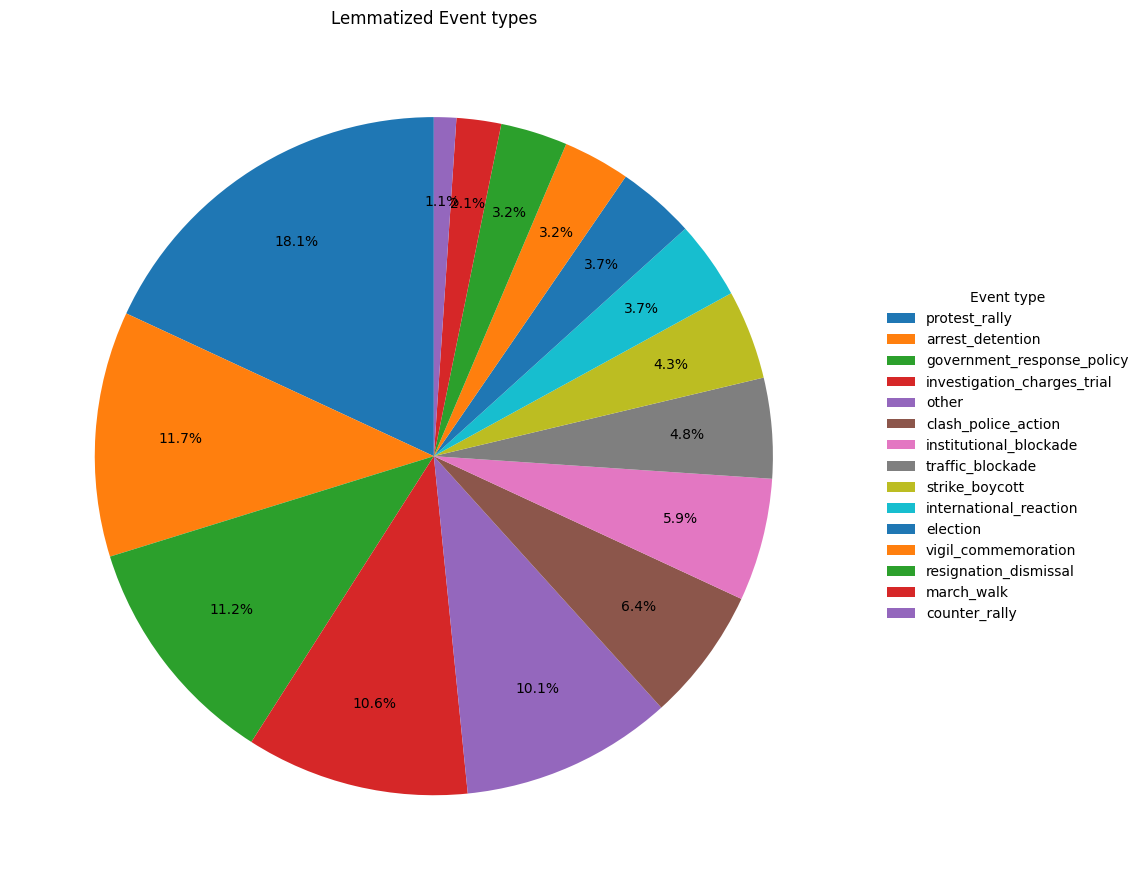

In [75]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 9))

wedges, _, autotexts = ax.pie(
    counts.values,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.75,
    textprops={"fontsize": 10},
)

ax.legend(
    wedges,
    counts.index,
    title="Event type",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)

ax.set_title("Lemmatized Event types")
plt.tight_layout()
plt.show()


In [82]:
non_lem = non_lem.apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

In [85]:
import pandas as pd
import ast





ev = non_lem[non_lem.apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()


ev = ev.explode()


ev["event_type"] = ev.apply(lambda d: d.get("event_type") if isinstance(d, dict) else None)

counts = ev["event_type"].value_counts()
counts

,count
events,
protest_rally,29
arrest_detention,14
investigation_charges_trial,12
clash_police_action,10
other,8
institutional_blockade,7
election,7
government_response_policy,6
march_walk,6


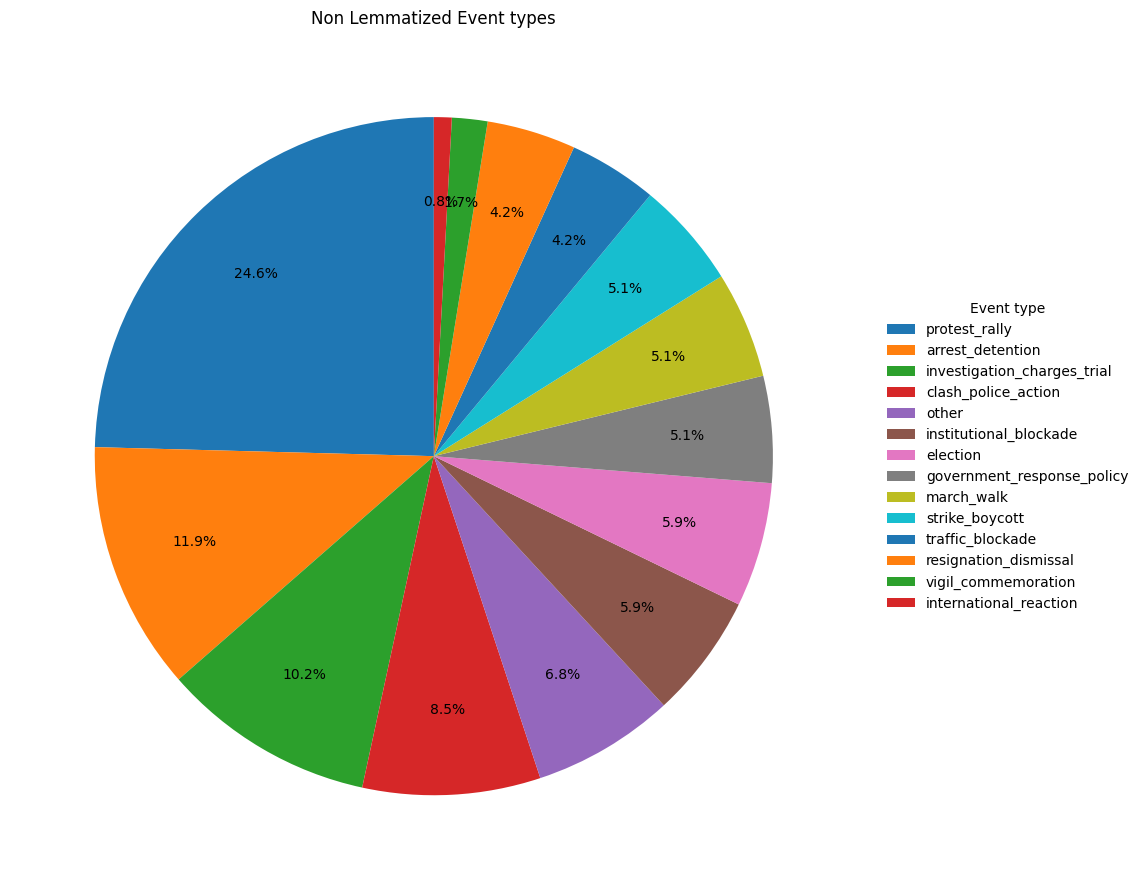

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 9))

wedges, _, autotexts = ax.pie(
    counts.values,
    labels=None,
    autopct="%1.1f%%",
    startangle=90,
    pctdistance=0.75,
    textprops={"fontsize": 10},
)

ax.legend(
    wedges,
    counts.index,
    title="Event type",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)

ax.set_title("Non Lemmatized Event types")
plt.tight_layout()
plt.show()
